# Coordinate descent for least squares with non-convex regularization

Author: Alexandre Gramfort, Joseph Salmon

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
from prox_collection import l22_prox, l1_prox, l0_prox, scad_prox, mcp_prox, \
    log_prox, sqrt_prox, enet_prox
from prox_collection import l22_objective, l1_objective, l0_objective, \
    scad_objective, mcp_objective, log_objective, sqrt_objective, \
    enet_objective
from prox_collection import l22_pen, l1_pen, l0_pen, \
    scad_pen, mcp_pen, log_pen, sqrt_pen, \
    enet_pen

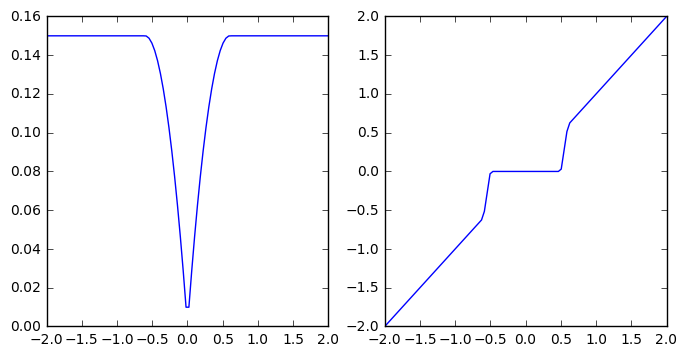

In [3]:
x = np.linspace(-2, 2, 100)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.plot(x, list(map(lambda y: mcp_pen(y, threshold=0.5, gamma=1.2), x)))
ax2.plot(x, list(map(lambda y: mcp_prox(y, threshold=0.5, gamma=1.2), x)))

## Generate simulated data

$y = xw+b+noise$

In [4]:
np.random.seed(0)
n_samples, n_features = 300, 100
A = np.random.randn(n_samples, n_features)
x_true = np.zeros(n_features)
x_true[5] = 3
x_true[12] = -2
x_true[40] = 5
y = np.dot(A, x_true)
y += 0.3 * np.random.randn(n_samples)

## Cyclic coordinate descent

Solve:

$\min_x \frac{1}{2} \|y - Ax\|^2 + \alpha\ {\rm pen}(x)$

<Container object of 3 artists>

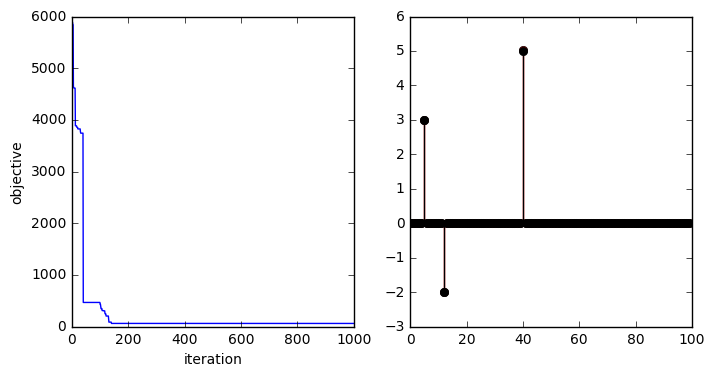

In [5]:
alpha = 100.

def pen(x):
    return np.array(list(map(lambda y: l1_pen(y, threshold=0.5), x)))
    
def objective(x):
    return 0.5 * linalg.norm(A.dot(x) - y)**2 + alpha * np.sum(pen(x))

def prox(x, threshold):
    return l1_prox(x, threshold=threshold)

if True:
    def pen(x):
        return np.array(list(map(lambda y: mcp_pen(y, threshold=0.5, gamma=1.2), x)))

    def objective(x):
        return 0.5 * linalg.norm(A.dot(x) - y)**2 + alpha * np.sum(pen(x))

    def prox(x, threshold):
        return mcp_prox(x, threshold=threshold, gamma=1.2)


Li = np.sum(A * A, axis=0)
n_iter = 10 * n_features

x_hat = np.zeros_like(x)
objs = list()
for k in range(n_iter):
    i = k % n_features
    x_hat[i] = np.dot(A[:, i].T, y - np.dot(A, x_hat) + x_hat[i] * A[:, i])
    x_hat[i] /= Li[i]
    x_hat[i] = prox(x_hat[i], alpha / Li[i])
    objs.append(objective(x_hat))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.plot(objs)
ax1.set_xlabel('iteration')
ax1.set_ylabel('objective')
ax2.stem(x_hat, linefmt='r-', markerfmt='ro', basefmt='r-')
ax2.stem(x_true, linefmt='k-', markerfmt='ko', basefmt='k-')

### or written in a more generic manner:

<Container object of 3 artists>

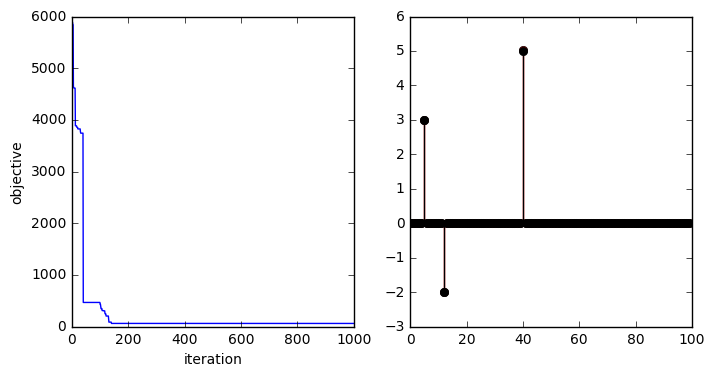

In [9]:
def gradient_i(x, i):
    return np.dot(A[:, i].T, np.dot(A, x) - y)

Li = np.sum(A * A, axis=0)

n_iter = 10 * n_features

x_hat = np.zeros_like(x)
objs = list()
for k in range(n_iter):
    i = k % n_features
    x_hat[i] -= 1. / Li[i] * gradient_i(x_hat, i)
    x_hat[i] = prox(x_hat[i], alpha / Li[i])
    objs.append(objective(x_hat))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.plot(objs)
ax1.set_xlabel('iteration')
ax1.set_ylabel('objective')
ax2.stem(x_hat, linefmt='r-', markerfmt='ro', basefmt='r-')
ax2.stem(x_true, linefmt='k-', markerfmt='ko', basefmt='k-')